<a href="https://colab.research.google.com/github/Krixna-Kant/NEST_RR_prediction/blob/main/squirtle_rr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving usecase_4_.xlsx to usecase_4_.xlsx


# Data Preprocessing

**Frameworks Install**

In [4]:
!pip install pandas numpy scikit-learn xgboost shap streamlit matplotlib seaborn fastapi uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


**Dataset handling**

In [3]:
import pandas as pd

dataset = pd.read_excel('/content/usecase_4_.xlsx')
print(dataset.info())
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20676 entries, 0 to 20675
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   NCT Number                  20676 non-null  object        
 1   Study Title                 20676 non-null  object        
 2   Study URL                   20676 non-null  object        
 3   Study Status                20676 non-null  object        
 4   Brief Summary               20676 non-null  object        
 5   Study Results               20676 non-null  object        
 6   Conditions                  20676 non-null  object        
 7   Interventions               20676 non-null  object        
 8   Primary Outcome Measures    20676 non-null  object        
 9   Secondary Outcome Measures  17757 non-null  object        
 10  Other Outcome Measures      1729 non-null   object        
 11  Sponsor                     20676 non-null  object    

**Data Cleaning**

In [5]:
import pandas as pd

missing_values = dataset.isnull().sum()
print(missing_values)

NCT Number                        0
Study Title                       0
Study URL                         0
Study Status                      0
Brief Summary                     0
Study Results                     0
Conditions                        0
Interventions                     0
Primary Outcome Measures          0
Secondary Outcome Measures     2919
Other Outcome Measures        18947
Sponsor                           0
Collaborators                 14857
Sex                               6
Age                               0
Phases                            0
Enrollment                        0
Funder Type                       0
Study Type                        0
Study Design                      0
Other IDs                         0
Start Date                        0
Primary Completion Date           0
Completion Date                   1
First Posted                      0
Results First Posted          13002
Last Update Posted                0
Locations                   

**Filling missing categorical values**

In [6]:
categorical_columns = ['Secondary Outcome Measures', 'Other Outcome Measures', 'Collaborators', 'Sex']
for col in categorical_columns:
    dataset[col] =  dataset[col].fillna(dataset[col].mode()[0])

**Filling missing datatime columns**

In [7]:
datetime_columns = ['Completion Date', 'Results First Posted']
for col in datetime_columns:
    dataset[col] = dataset[col].fillna(dataset[col].median())

In [ ]:
print("Updated Missing Values:\n", dataset.isnull().sum())

Updated Missing Values:
 NCT Number                    0
Study Title                   0
Study URL                     0
Study Status                  0
Brief Summary                 0
Study Results                 0
Conditions                    0
Interventions                 0
Primary Outcome Measures      0
Secondary Outcome Measures    0
Other Outcome Measures        0
Sponsor                       0
Collaborators                 0
Sex                           0
Age                           0
Phases                        0
Enrollment                    0
Funder Type                   0
Study Type                    0
Study Design                  0
Other IDs                     0
Start Date                    0
Primary Completion Date       0
Completion Date               0
First Posted                  0
Results First Posted          0
Last Update Posted            0
Locations                     0
Study Recruitment Rate        0
dtype: int64


**Feature Engineering (Internal factors)**

In [8]:
#Encode categorical variables into numerical formats
import numpy as np

dataset['Phases'] = dataset['Phases'].astype('category').cat.codes
dataset['Study Type'] = dataset['Study Type'].astype('category').cat.codes
dataset['Funder Type'] = dataset['Funder Type'].astype('category').cat.codes

#Log-transform Enrollment for normalization
dataset['Log Enrollment'] = np.log1p(dataset['Enrollment'])

# Number of locations (Geography)
dataset['Number of Locations'] = dataset['Locations'].apply(lambda x: len(x.split('|')))

# Derive Study Duration in Days
dataset['Study Duration'] = (dataset['Completion Date'] - dataset['Start Date']).dt.days

#Verify Engineered Features (Internal Features)
print(dataset[['Phases', 'Study Type', 'Funder Type', 'Log Enrollment', 'Number of Locations', 'Study Duration']].head())

   Phases  Study Type  Funder Type  Log Enrollment  Number of Locations  \
0       0           0            2        2.079442                    1   
1       1           0            2        3.806662                    5   
2       1           0            2        3.850148                   27   
3       3           0            2        4.043051                    2   
4       2           0            2        6.747587                   14   

   Study Duration  
0             386  
1             604  
2            1163  
3             117  
4             939  


**Feature Engineering (External factors)**

In [16]:
import numpy as np
from collections import Counter

# Competition Index: Count the trials by region in Locations
location_counts = Counter([loc for sublist in dataset['Locations'].str.split('|') for loc in sublist])
dataset['Competition Index'] = dataset['Locations'].apply(
    lambda x: sum(location_counts[loc] for loc in x.split('|'))
)

# Disease Rarity Index: Frequency of each condition
condition_counts = dataset['Conditions'].value_counts()
dataset['Disease Rarity'] = dataset['Conditions'].map(condition_counts)

# Normalize Competition Index by the maximum value to scale between 0 and 1
dataset['Normalized Competition Index'] = dataset['Competition Index'] / dataset['Competition Index'].max()

# Derived Feature: Trial Intensity in Region
dataset['Trial Intensity'] = (
    dataset['Normalized Competition Index'] * dataset['Disease Rarity'] / (dataset['Number of Locations'] + 1e-5)
)

# Derived Feature: SOC vs. Trial Condition Gap
# Placeholder for SOC availability metric (requires external data augmentation)
dataset['SOC Gap'] = dataset['Disease Rarity'] / (dataset['Number of Locations'] + 1)

# Verify the engineered features
print(dataset[['Competition Index', 'Disease Rarity', 'Trial Intensity', 'SOC Gap']].head())

   Competition Index  Disease Rarity  Trial Intensity    SOC Gap
0                  1              56         0.013523  28.000000
1                  8               9         0.003477   1.500000
2                 27               1         0.000241   0.035714
3                  2               1         0.000241   0.333333
4                 24               6         0.002484   0.400000


Graph (Checking part)

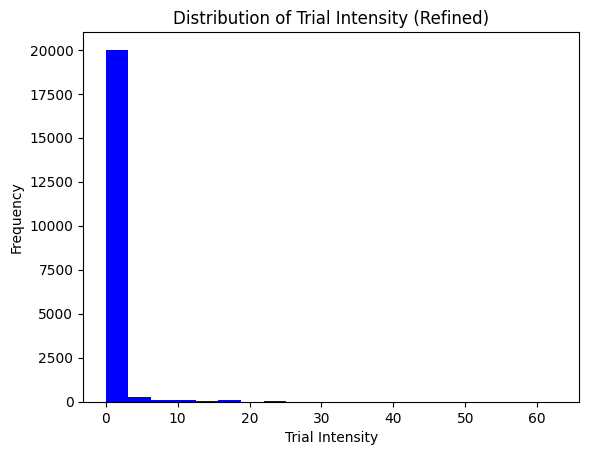

In [17]:
import matplotlib.pyplot as plt

plt.hist(dataset['Trial Intensity'], bins=20, color='blue')
plt.title('Distribution of Trial Intensity (Refined)')
plt.xlabel('Trial Intensity')
plt.ylabel('Frequency')
plt.show()

# **EDA**

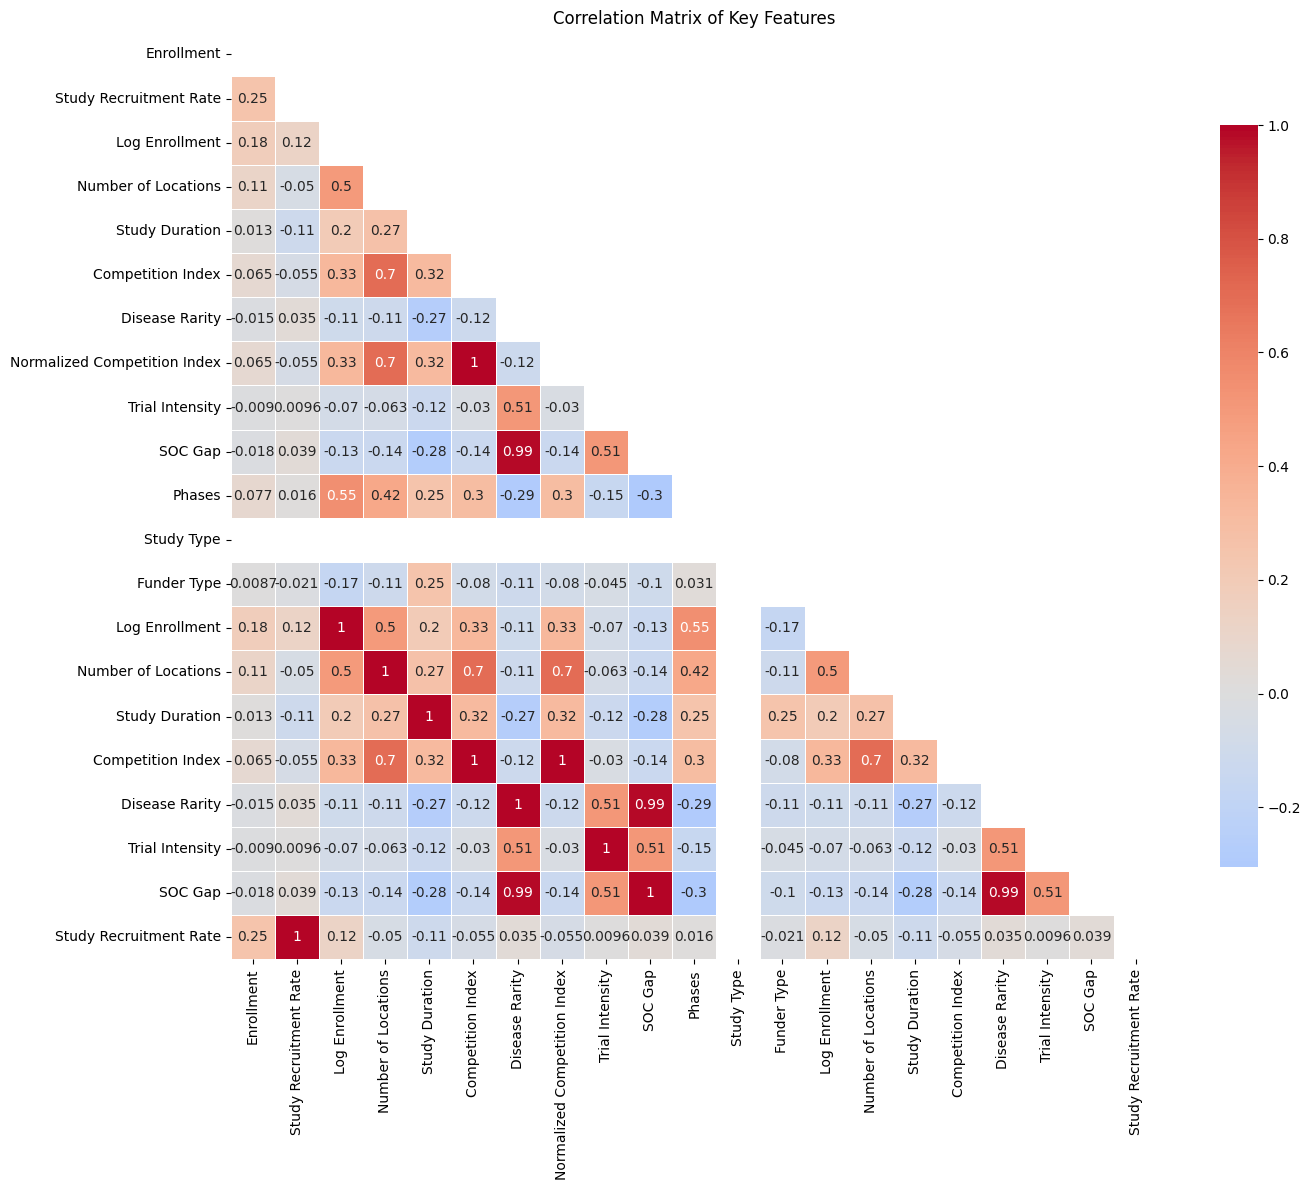

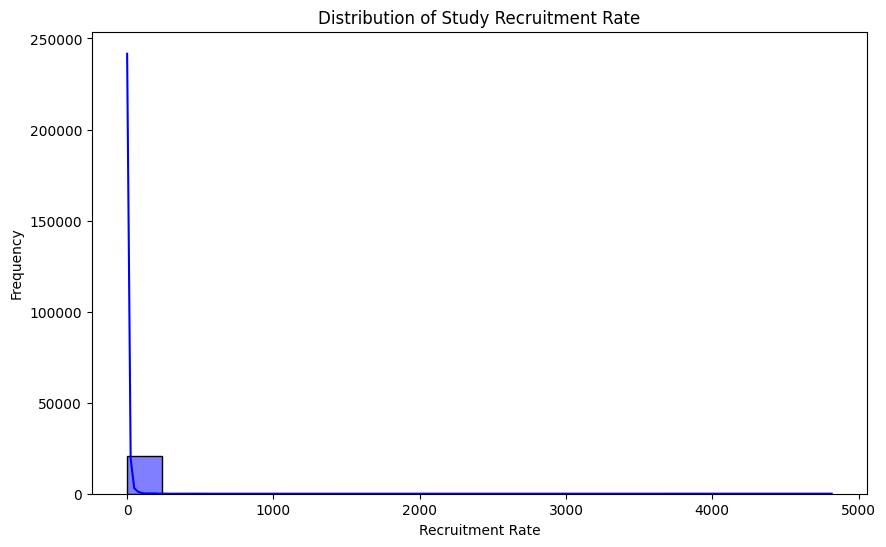

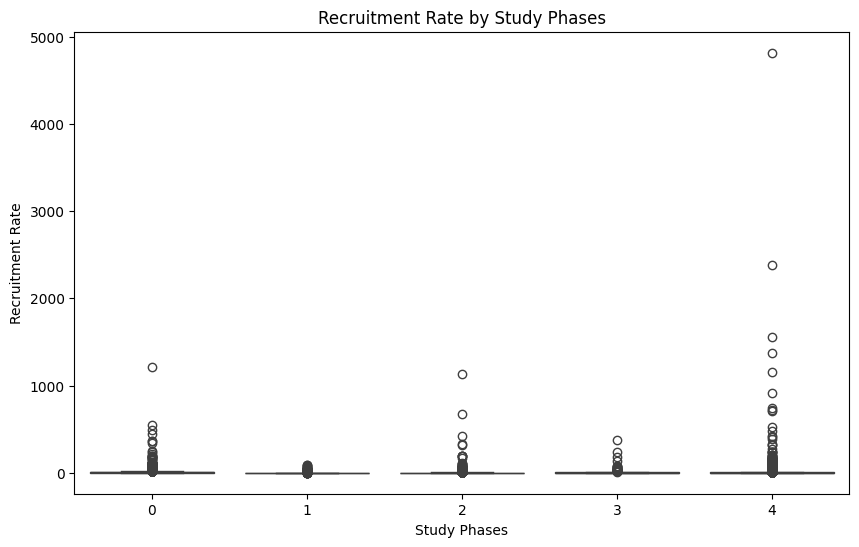

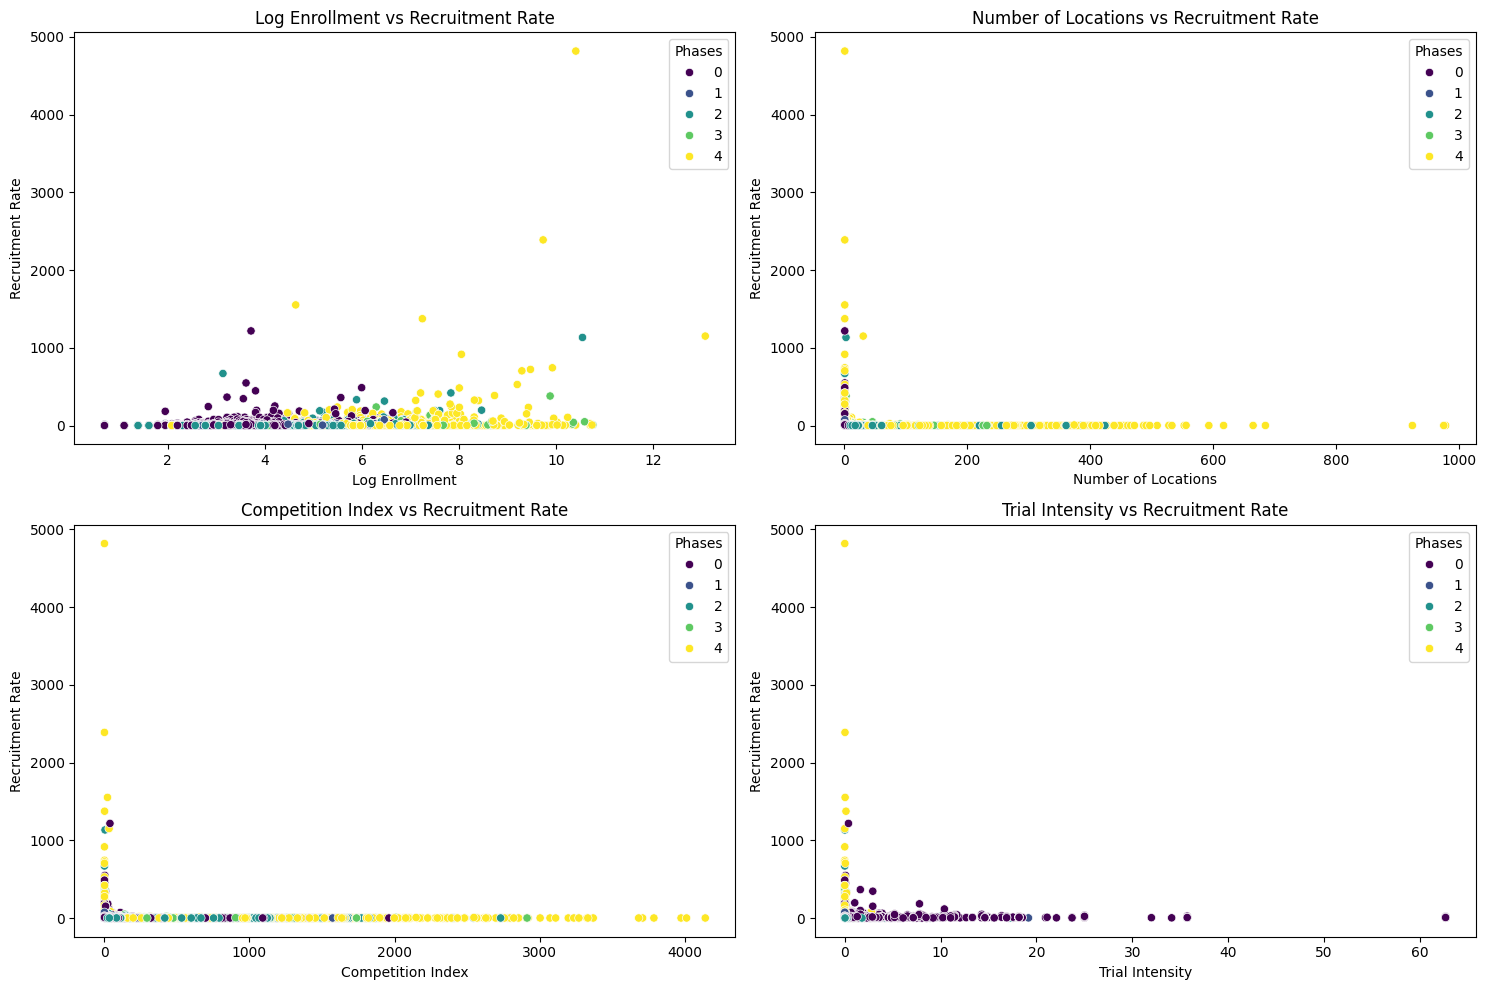


Descriptive Statistics of Key Features:
          Enrollment  Study Recruitment Rate  Log Enrollment  \
count   20676.000000            20676.000000    20676.000000   
mean      235.291159                6.680254        4.062218   
std      3534.300168               47.610877        1.385924   
min         1.000000                0.001128        0.693147   
25%        23.000000                0.169638        3.178054   
50%        48.000000                0.829898        3.891820   
75%       135.000000                5.249065        4.912655   
max    477102.000000             4816.602871       13.075488   

       Number of Locations  Study Duration  Competition Index  Disease Rarity  \
count         20676.000000    20676.000000       20676.000000    20676.000000   
mean             17.702215      689.568437         136.677452      132.100987   
std              43.062711      600.418206         309.874495      338.495421   
min               1.000000        1.000000           1.000

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comprehensive EDA
def perform_eda(dataset):
    # Select features for analysis

    # Select numerical features for analysis dynamically
    numerical_features = dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_features += ['Phases', 'Study Type', 'Funder Type','Log Enrollment', 'Number of Locations', 'Study Duration', 'Competition Index', 'Disease Rarity', 'Trial Intensity', 'SOC Gap', 'Study Recruitment Rate']  # Include important categorical features

    # 1. Correlation Matrix
    plt.figure(figsize=(15, 12))
    correlation_matrix = dataset[numerical_features].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        linewidths=0.5,
        mask=mask,
        center=0,
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title("Correlation Matrix of Key Features")
    plt.tight_layout()
    plt.savefig("correlation_matrix.png")
    plt.show()

    # 2. Distribution of Recruitment Rate
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset['Study Recruitment Rate'], kde=True, color="blue", bins=20)
    plt.title('Distribution of Study Recruitment Rate')
    plt.xlabel('Recruitment Rate')
    plt.ylabel('Frequency')
    plt.savefig("recruitment_rate_distribution.png")
    plt.show()

    # 3. Box Plot of Recruitment Rate by Phases
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Phases', y='Study Recruitment Rate', data=dataset)
    plt.title('Recruitment Rate by Study Phases')
    plt.xlabel('Study Phases')
    plt.ylabel('Recruitment Rate')
    plt.savefig("boxplot_phases_vs_recruitment_rate.png")
    plt.show()

    # 4. Scatter Plot of Key Features
    scatter_features = [
        ('Log Enrollment', 'Log Enrollment vs Recruitment Rate'),
        ('Number of Locations', 'Number of Locations vs Recruitment Rate'),
        ('Competition Index', 'Competition Index vs Recruitment Rate'),
        ('Trial Intensity', 'Trial Intensity vs Recruitment Rate')
    ]

    plt.figure(figsize=(15, 10))
    for i, (feature, title) in enumerate(scatter_features, 1):
        plt.subplot(2, 2, i)
        sns.scatterplot(x=feature, y='Study Recruitment Rate', data=dataset, hue='Phases', palette='viridis')
        plt.title(title)
        plt.xlabel(feature)
        plt.ylabel('Recruitment Rate')
    plt.tight_layout()
    plt.savefig("scatter_plots.png")
    plt.show()

    # 5. Descriptive Statistics
    print("\nDescriptive Statistics of Key Features:")
    print(dataset[numerical_features].describe())

# Perform EDA
perform_eda(dataset)

In [16]:
!pip install --upgrade scikit-learn xgboost

# **Model Building**

Dataset shape: (186, 29)
Columns: ['NCT Number', 'Study Title', 'Study URL', 'Study Status', 'Brief Summary', 'Study Results', 'Conditions', 'Interventions', 'Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Sex', 'Age', 'Phases', 'Enrollment', 'Funder Type', 'Study Type', 'Study Design', 'Other IDs', 'Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted', 'Locations', 'Study Recruitment Rate']

Training data shape: (148, 10)
Test data shape: (38, 10)
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...

Model Performance Comparison:

Random Forest:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 4.432995598476733
MAE: 1.7424963184357405
R²: 0.0853240320803551

Gradient Boosting:
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE: 4.896423165509381
MAE: 1.6305598729689716
R²

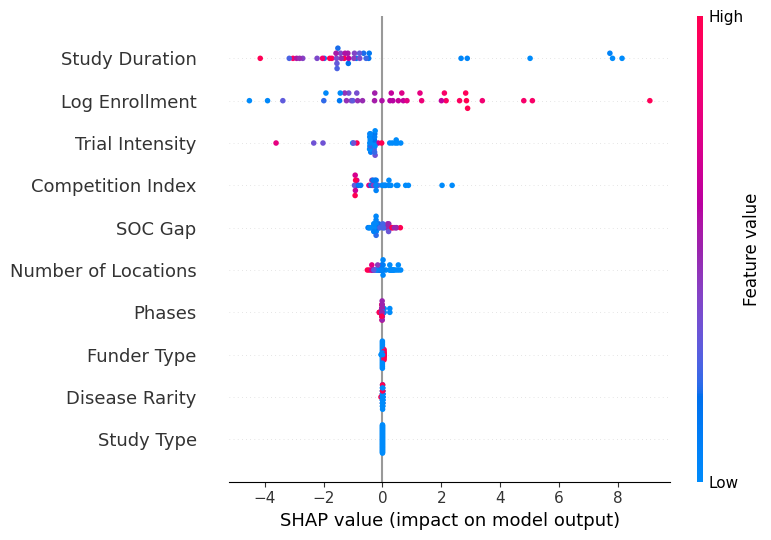

In [3]:
!pip install --upgrade scikit-learn==1.2.0
!pip install --upgrade xgboost==1.7.5

# Data manipulation and scientific computing
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Gradient boosting
from xgboost.sklearn import XGBRegressor

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt

# Model interpretability
import shap

def prepare_data(dataset):
    # Convert categorical columns to numerical codes
    dataset['Phases'] = dataset['Phases'].astype('category').cat.codes
    dataset['Study Type'] = dataset['Study Type'].astype('category').cat.codes
    dataset['Funder Type'] = dataset['Funder Type'].astype('category').cat.codes

    # Log-transform Enrollment
    dataset['Log Enrollment'] = np.log1p(dataset['Enrollment'])

    # Number of locations
    dataset['Number of Locations'] = dataset['Locations'].apply(lambda x: len(str(x).split('|')))

    # Study Duration
    dataset['Study Duration'] = (pd.to_datetime(dataset['Completion Date']) - pd.to_datetime(dataset['Start Date'])).dt.days

    # Competition Index
    from collections import Counter
    location_counts = Counter([loc for sublist in dataset['Locations'].str.split('|') for loc in sublist])
    dataset['Competition Index'] = dataset['Locations'].apply(
        lambda x: sum(location_counts.get(loc, 0) for loc in str(x).split('|'))
    )

    # Disease Rarity
    condition_counts = dataset['Conditions'].value_counts()
    dataset['Disease Rarity'] = dataset['Conditions'].map(condition_counts)

    # Normalized Competition Index
    dataset['Normalized Competition Index'] = dataset['Competition Index'] / dataset['Competition Index'].max()

    # Trial Intensity
    dataset['Trial Intensity'] = (
        dataset['Normalized Competition Index'] * dataset['Disease Rarity'] / (dataset['Number of Locations'] + 1e-5)
    )

    # SOC Gap
    dataset['SOC Gap'] = dataset['Disease Rarity'] / (dataset['Number of Locations'] + 1)

    # Select features for modeling
    features = [
        'Phases', 'Study Type', 'Funder Type',
        'Log Enrollment', 'Number of Locations',
        'Study Duration', 'Competition Index',
        'Disease Rarity', 'Trial Intensity',
        'SOC Gap'
    ]

    # Check for missing columns
    missing_columns = [col for col in features if col not in dataset.columns]
    if missing_columns:
        raise KeyError(f"Missing columns in dataset: {missing_columns}")

    X = dataset[features]
    y = dataset['Study Recruitment Rate']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10],
                'min_samples_split': [2, 5]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        }
    }

    results = {}
    best_models = {}

    for name, model_info in models.items():
        try:
            print(f"Training {name}...")
            grid_search = GridSearchCV(
                model_info['model'],
                model_info['params'],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_models[name] = best_model

            y_pred = best_model.predict(X_test)
            results[name] = {
                'Best Params': grid_search.best_params_,
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R²': r2_score(y_test, y_pred)
            }
        except Exception as e:
            print(f"Error with {name}: {e}")

    return results, best_models

def model_explainability(model, X_test, feature_names):
    # SHAP Explainability
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # SHAP Summary Plot
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    # plt.title('SHAP Feature Importance')
    # plt.show()

def main():
    # Load dataset
    dataset = pd.read_excel("/usecase_4_.xlsx")
    dataset = dataset.dropna()  # Ensure no missing values
    print("Dataset shape:", dataset.shape)
    print("Columns:", list(dataset.columns))

    # Prepare data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(dataset)
    print("\nTraining data shape:", X_train_scaled.shape)
    print("Test data shape:", X_test_scaled.shape)

    # Train and evaluate models
    model_results, best_models = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

    # Print results
    print("\nModel Performance Comparison:")
    for name, metrics in model_results.items():
        print(f"\n{name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

    # Select and save best model
    best_model_name = min(model_results, key=lambda x: model_results[x]['RMSE'])
    best_model = best_models[best_model_name]
    joblib.dump(best_model, "best_model.pkl")
    print(f"Best model saved: {best_model_name}")

    # Model explainability
    feature_names = [
        'Phases', 'Study Type', 'Funder Type',
        'Log Enrollment', 'Number of Locations',
        'Study Duration', 'Competition Index',
        'Disease Rarity', 'Trial Intensity',
        'SOC Gap'
    ]

    model_explainability(best_model, X_test_scaled, feature_names)

if __name__ == "__main__":
    main()



*Frameworks*

In [6]:
pip install pandas numpy streamlit plotly openpyxl pyngrok

# **Dynamic Benchmarking Code**

In [26]:
import pandas as pd
import numpy as np
import streamlit as st
import plotly.express as px

# Load the dataset
file_path = "/usecase_4_.xlsx"
data = pd.read_excel(file_path)

# Preprocess the dataset
# Extract relevant columns
data = data[["Phases", "Locations", "Study Recruitment Rate"]]

# Extract Region from Locations
def extract_region(location):
    if pd.isna(location):
        return "Unknown"
    if "North America" in location:
        return "North America"
    elif "Europe" in location:
        return "Europe"
    elif "Asia" in location:
        return "Asia"
    else:
        return "Other"

data["Region"] = data["Locations"].apply(extract_region)

# Rename columns for consistency
data.rename(columns={"Phases": "Study Phase"}, inplace=True)

# Handle missing data
data.dropna(subset=["Study Recruitment Rate"], inplace=True)
data["Study Phase"] = data["Study Phase"].fillna("Unknown")
data["Region"] = data["Region"].fillna("Unknown")

# Streamlit App
st.title("Dynamic Benchmarking for Recruitment Rates")

# Sidebar Filters
st.sidebar.header("Filters")
selected_phase = st.sidebar.selectbox("Select Study Phase", data["Study Phase"].unique())
selected_region = st.sidebar.selectbox("Select Region", data["Region"].unique())

# Calculate Benchmarks
filtered_data = data[
    (data["Study Phase"] == selected_phase) &
    (data["Region"] == selected_region)
]

# Display Benchmark
if not filtered_data.empty:
    benchmark_avg = filtered_data["Study Recruitment Rate"].mean()
    st.subheader("Benchmark Results")
    st.write(f"Average Recruitment Rate for {selected_phase} in {selected_region}: **{benchmark_avg:.2f}**")
else:
    st.warning("No data available for the selected filters.")

# Visualize Recruitment Rates
st.subheader("Recruitment Rates by Study Phase and Region")
fig = px.bar(data, x="Study Phase", y="Study Recruitment Rate", color="Region", barmode="group")
st.plotly_chart(fig)

2025-01-26 16:37:51.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.718 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.722 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:51.731 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

**Adding Predictions features to the App**

In [19]:
import joblib
best_model = ...  # Your trained model
joblib.dump(best_model, "/content/best_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [25]:
import joblib

# Load the saved model
model_path = "/content/best_model.pkl"  # Ensure this matches your saved model file
model = joblib.load(model_path)

# File uploader for new data
uploaded_file = st.file_uploader("Upload a Excel or CSV file for prediction", type=["xlsx", "csv"])

if uploaded_file:
     # Check the file type
    if uploaded_file.name.endswith(".csv"):
        # Load CSV file
        new_data = pd.read_csv(uploaded_file)
    elif uploaded_file.name.endswith(".xlsx"):
        # Load Excel file
        new_data = pd.read_excel(uploaded_file)
    else:
        st.error("Unsupported file type. Please upload a .csv or .xlsx file.")

    # Display the uploaded data
    st.write("Uploaded Data:")
    st.dataframe(new_data)

    # Proceed with preprocessing and prediction
    try:
        # Add preprocessing and prediction logic here
        # Preprocess the new data (similar to training data preparation)
        new_data['Log Enrollment'] = np.log1p(new_data['Enrollment'])
        new_data['Number of Locations'] = new_data['Locations'].apply(lambda x: len(str(x).split('|')))
        location_counts = Counter([loc for sublist in new_data['Locations'].str.split('|') for loc in sublist])
        new_data['Competition Index'] = new_data['Locations'].apply(
            lambda x: sum(location_counts.get(loc, 0) for loc in str(x).split('|'))
        )
        condition_counts = new_data['Conditions'].value_counts()
        new_data['Disease Rarity'] = new_data['Conditions'].map(condition_counts)
        new_data['Normalized Competition Index'] = new_data['Competition Index'] / new_data['Competition Index'].max()
        new_data['Trial Intensity'] = (
            new_data['Normalized Competition Index'] * new_data['Disease Rarity'] / (new_data['Number of Locations'] + 1e-5)
        )
        new_data['SOC Gap'] = new_data['Disease Rarity'] / (new_data['Number of Locations'] + 1)

        features = [
            'Phases', 'Study Type', 'Funder Type',
            'Log Enrollment', 'Number of Locations',
            'Study Duration', 'Competition Index',
            'Disease Rarity', 'Trial Intensity',
            'SOC Gap'
        ]
        X_new = new_data[features]

        # Predict recruitment rates
        predictions = model.predict(X_new)
        new_data['Predicted Recruitment Rate'] = predictions

        # Show results
        st.write("Predictions:")
        st.dataframe(new_data[['NCT Number', 'Predicted Recruitment Rate']])

        # Option to download predictions
        st.download_button(
            label="Download Predictions",
            data=new_data.to_csv(index=False).encode('utf-8'),
            file_name="predictions.csv",
            mime='text/csv'
        )
    except Exception as e:
        st.error(f"An error occurred: {e}")

2025-01-26 16:34:41.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:34:41.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:34:41.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:34:41.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:34:41.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


# **Combining Benchmarking and Predictions**

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

def prepare_data(dataset):
    # Select and preprocess features
    feature_columns = [
        'Enrollment', 'Sex', 'Age', 'Phases',
        'Funder Type', 'Study Type', 'Study Design',
        'Conditions', 'Interventions', 'Primary Outcome Measures'
    ]

    # Create a copy to avoid SettingWithCopyWarning
    data_processed = dataset.copy()

    # Encode categorical columns
    label_encoders = {}
    for col in feature_columns:
        if data_processed[col].dtype == 'object':
            le = LabelEncoder()
            data_processed[col] = le.fit_transform(data_processed[col].astype(str))
            label_encoders[col] = le

    # Prepare X and y
    X = data_processed[feature_columns]
    y = dataset['Study Recruitment Rate']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def combine_benchmarking_and_predictions(dataset, y_test, predictions, benchmark_rate=0.5):
    comparison_df = pd.DataFrame({
        'Study ID': dataset.loc[y_test.index, 'NCT Number'],
        'Actual Recruitment Rate': y_test.values,
        'Predicted Recruitment Rate': predictions,
        'Benchmark Rate': benchmark_rate,
        'Deviation from Benchmark': predictions - benchmark_rate
    })

    return comparison_df.round(4)

def main():
    # Load data
    dataset = pd.read_excel("/usecase_4_.xlsx")
    dataset = dataset.dropna(subset=['Study Recruitment Rate'])  # Drop rows with missing recruitment rates

    # Prepare data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(dataset)

    # Load best model
    best_model = joblib.load("best_model.pkl")

    # Generate predictions
    predictions = best_model.predict(X_test_scaled)

    # Create comparison table
    comparison_table = combine_benchmarking_and_predictions(dataset, y_test, predictions)

    # Display and save results
    print("Comparison Table:")
    print(comparison_table.head())
    comparison_table.to_csv('comparison_table.csv', index=False)
    print("Comparison table saved as 'comparison_table.csv'.")

if __name__ == "__main__":
    main()

Comparison Table:
          Study ID  Actual Recruitment Rate  Predicted Recruitment Rate  \
14371  NCT04645446                   1.1851                      0.5068   
18347  NCT05471648                  16.2302                      0.2440   
9398   NCT03789318                   8.5995                      1.4756   
8375   NCT03638206                   1.2160                      1.1685   
5047   NCT03177278                   7.6042                      0.4604   

       Benchmark Rate  Deviation from Benchmark  
14371             0.5                    0.0068  
18347             0.5                   -0.2560  
9398              0.5                    0.9756  
8375              0.5                    0.6685  
5047              0.5                   -0.0396  
Comparison table saved as 'comparison_table.csv'.


# **Visulization Part**

In [17]:
!pip install plotly scikit-learn pandas joblib openpyxl

In [20]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import os

def create_visualizations(dataset, y_test, predictions):
    # Ensure output directory exists
    os.makedirs('/content/visualization_outputs', exist_ok=True)

    # Comparison DataFrame
    comparison_df = pd.DataFrame({
        'Study ID': dataset.loc[y_test.index, 'NCT Number'],
        'Actual Recruitment Rate': y_test.values,
        'Predicted Recruitment Rate': predictions
    })

    # 1. Actual vs Predicted Scatter Plot
    fig1 = px.scatter(
        comparison_df,
        x='Actual Recruitment Rate',
        y='Predicted Recruitment Rate',
        hover_data=['Study ID'],
        title='Actual vs Predicted Recruitment Rates'
    )
    fig1.add_trace(
        go.Scatter(
            x=[comparison_df['Actual Recruitment Rate'].min(), comparison_df['Actual Recruitment Rate'].max()],
            y=[comparison_df['Actual Recruitment Rate'].min(), comparison_df['Actual Recruitment Rate'].max()],
            mode='lines',
            name='Perfect Prediction',
            line=dict(color='red', dash='dash')
        )
    )
    output_path1 = '/content/visualization_outputs/actual_vs_predicted.html'
    fig1.write_html(output_path1)
    print(f"Scatter plot saved to: {output_path1}")

    # 2. Distribution of Recruitment Rates
    fig2 = go.Figure()
    fig2.add_trace(go.Histogram(x=y_test.values, name='Actual Rates'))
    fig2.add_trace(go.Histogram(x=predictions, name='Predicted Rates'))
    fig2.update_layout(
        title='Distribution of Recruitment Rates',
        xaxis_title='Recruitment Rate',
        yaxis_title='Frequency',
        barmode='overlay'
    )
    output_path2 = '/content/visualization_outputs/recruitment_rates_distribution.html'
    fig2.write_html(output_path2)
    print(f"Distribution plot saved to: {output_path2}")

    # 3. Error Analysis
    comparison_df['Absolute Error'] = np.abs(comparison_df['Actual Recruitment Rate'] - comparison_df['Predicted Recruitment Rate'])
    fig3 = px.bar(
        comparison_df,
        x='Study ID',
        y='Absolute Error',
        title='Absolute Prediction Errors'
    )
    output_path3 = '/content/visualization_outputs/prediction_errors.html'
    fig3.write_html(output_path3)
    print(f"Error analysis plot saved to: {output_path3}")

    # Save comparison table
    comparison_table_path = '/content/visualization_outputs/comparison_table.csv'
    comparison_df.to_csv(comparison_table_path, index=False)
    print(f"Comparison table saved to: {comparison_table_path}")

    print("Visualizations and analysis completed successfully.")

    return comparison_df

def main():
    # Load data
    dataset = pd.read_excel("/usecase_4_.xlsx")
    dataset = dataset.dropna(subset=['Study Recruitment Rate'])

    # Prepare data
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder

    feature_columns = [
        'Enrollment', 'Sex', 'Age', 'Phases',
        'Funder Type', 'Study Type', 'Study Design',
        'Conditions', 'Interventions', 'Primary Outcome Measures'
    ]

    # Encode categorical columns
    data_processed = dataset.copy()
    for col in feature_columns:
        if data_processed[col].dtype == 'object':
            le = LabelEncoder()
            data_processed[col] = le.fit_transform(data_processed[col].astype(str))

    X = data_processed[feature_columns]
    y = dataset['Study Recruitment Rate']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Load best model
    import joblib
    best_model = joblib.load("/content/best_model.pkl")

    # Generate predictions
    predictions = best_model.predict(X_test_scaled)

    # Create visualizations
    create_visualizations(dataset, y_test, predictions)

if __name__ == "__main__":
    main()

Scatter plot saved to: /content/visualization_outputs/actual_vs_predicted.html
Distribution plot saved to: /content/visualization_outputs/recruitment_rates_distribution.html
Error analysis plot saved to: /content/visualization_outputs/prediction_errors.html
Comparison table saved to: /content/visualization_outputs/comparison_table.csv
Visualizations and analysis completed successfully.


In [22]:
from google.colab import files

# List files in the output directory
!ls /content/visualization_outputs/

# If you want to download the HTML files
files.download('/content/visualization_outputs/actual_vs_predicted.html')
files.download('/content/visualization_outputs/recruitment_rates_distribution.html')
files.download('/content/visualization_outputs/prediction_errors.html')

actual_vs_predicted.html  prediction_errors.html
comparison_table.csv	  recruitment_rates_distribution.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>